In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
## Load modules
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from scipy import stats

import matplotlib.colors as colors


import os
import joblib
import pickle
import sys

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from joblib import dump

sys.path.append('/home/freimax/msc_thesis/scripts/helpers/')
import helper

sys.path.append('/home/freimax/msc_thesis/scripts/random_forest/')
import rf_functions
sys.path.append('/home/freimax/msc_thesis/scripts/plotting_functions/')
import plot_helpers
import make_plots_traj

In [3]:
## Load training data

def load_data(train_val='train'):
    assert isinstance(train_val, str) and train_val in ['train', 'val'], "train_val should be a string and must be either 'train' or 'val'"
    
    monthlist = ['DEC17','JAN18','FEB18','MAR18','APR18','MAY18','JUN18','JUL18','AUG18','SEP18','OCT18','NOV18']
    # monthlist = ['DEC17','JAN18','MAR18','APR18','MAY18','JUN18','JUL18','AUG18','SEP18','OCT18','NOV18']
    path = '/net/helium/atmosdyn/freimax/data_msc/IFS-18/cyclones/data_random_forest'

    list_df_1month = []
    for month in monthlist:
        list_df_1month.append(pd.read_pickle(f'{path}/{month}/df_ifs_masked_{train_val}.pkl'))

    # Concatenate all dataframes in the list into a single dataframe
    print('Concatente all df to one')
    df = pd.concat(list_df_1month, ignore_index=True)

    # Cancel unallowed values (coolin rate positve)
    df[df['tmeltsi']>0] = 0
    df[df['tsubsi']>0] = 0
    df[df['tevr']>0] = 0

    return df

df_val = load_data('val')

Concatente all df to one


In [4]:
model_tsubsi, model_tmeltsi, model_tevr =  helper.load_rf_models()

                   *** Load Models ***                    
  Load model tsubsi
  Load model tmeltsi
  Load model tevr


In [5]:
## TSubSI
cols_target_features = ['tsubsi', 'SIWC', 'LWC', 'RWC', 'RH', 'Q', 'OMEGA', 'T']
df_val_tsubsi = df_val[cols_target_features]

df_tsubsi_val = rf_functions.apply_domainfilter(df=df_val_tsubsi,
                                                water_type='SIWC',
                                                verbose=1,
                                                temp_filter=False,output_filter=False)


# Define the predictors and the target
target = 'tsubsi'

X_val_tsubsi = df_tsubsi_val.drop([target], axis=1)
y_val_tsubsi = df_tsubsi_val[target]

y_pred_tsubsi = model_tsubsi.predict(X_val_tsubsi)

residuals_tsubsi = y_val_tsubsi - y_pred_tsubsi
# Calculate metrics
rmse_tsubsi = np.sqrt(mean_squared_error(y_val_tsubsi, y_pred_tsubsi))
r2_tsubsi  = r2_score(y_val_tsubsi, y_pred_tsubsi)

Drop all points where SIWC == 0


In [6]:
## Tmeltsi
cols_target_features = ['tmeltsi', 'SIWC', 'LWC', 'RWC', 'RH', 'Q', 'OMEGA', 'T']  
df_val_tmeltsi = df_val[cols_target_features]

df_tmeltsi_val = rf_functions.apply_domainfilter(df=df_val_tmeltsi,
                                                 water_type='SIWC',
                                                 verbose=1,
                                                 temp_filter=True,
                                                 output_filter=False)

# Define the predictors and the target
target = 'tmeltsi'

X_val_tmeltsi = df_tmeltsi_val.drop([target], axis=1)
y_val_tmeltsi = df_tmeltsi_val[target]

y_pred_tmeltsi = model_tmeltsi.predict(X_val_tmeltsi)

residuals_tmeltsi = y_val_tmeltsi - y_pred_tmeltsi
# Calculate metrics
rmse_tmeltsi = np.sqrt(mean_squared_error(y_val_tmeltsi, y_pred_tmeltsi))
r2_tmeltsi  = r2_score(y_val_tmeltsi, y_pred_tmeltsi)

Drop all points where SIWC == 0 and Temp < 0


In [7]:
## Tevr

## TSubSI
cols_target_features = ['tevr', 'SIWC', 'LWC', 'RWC', 'RH', 'Q', 'OMEGA', 'T']
df_val_tevr = df_val[cols_target_features]

df_tevr_val = rf_functions.apply_domainfilter(df=df_val_tevr,
                                                water_type='RWC',
                                                verbose=1,
                                                temp_filter=False,output_filter=False)


# Define the predictors and the target
target = 'tevr'

X_val_tevr = df_tevr_val.drop([target], axis=1)
y_val_tevr = df_tevr_val[target]

y_pred_tevr = model_tevr.predict(X_val_tevr)
residuals_tevr = y_val_tevr - y_pred_tevr

# Calculate metrics
rmse_tevr = np.sqrt(mean_squared_error(y_val_tevr, y_pred_tevr))
r2_tevr  = r2_score(y_val_tevr, y_pred_tevr)

Drop all points where RWC == 0


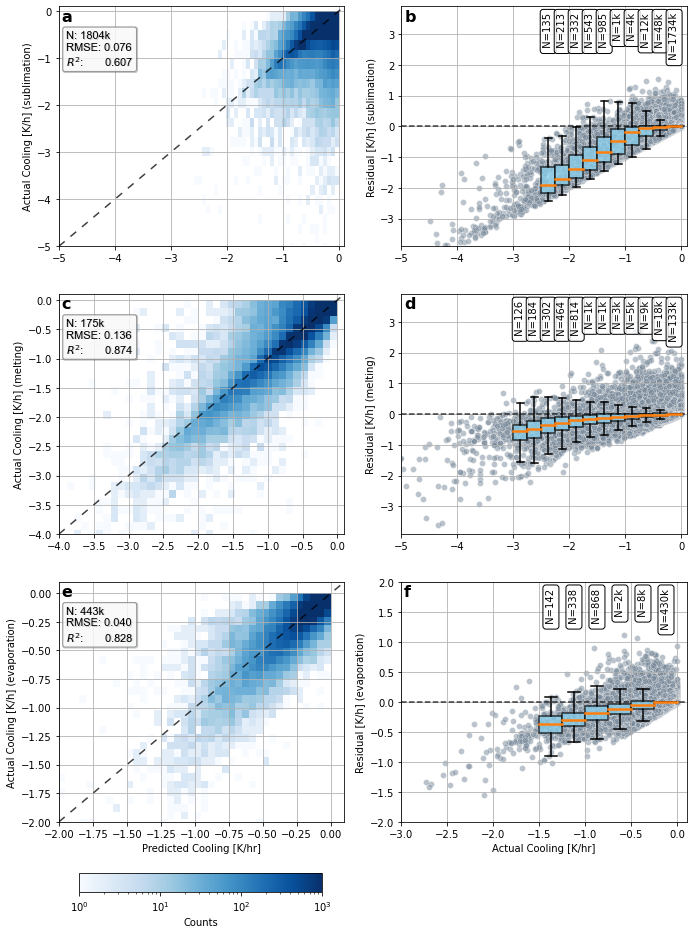

In [8]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(11.25,15))
hist_2d=[]
## tsubsi
hist2d = plot_helpers.plot_pred_vs_true(ax[0,0], y_true=y_val_tsubsi, y_pred=y_pred_tsubsi, xaxis_label=False, xrange=-5, ylabel_bcp='Actual Cooling [K/h] (sublimation)')
plot_helpers.plot_residuals(ax[0,1], y_true=y_val_tsubsi, y_pred=y_pred_tsubsi, xaxis_label=False, xrange=-5, yrange=3.9, ylabel_bcp='Residual [K/h] (sublimation)')
hist_2d.append(hist2d)
## tmeltsi
hist2d = plot_helpers.plot_pred_vs_true(ax[1,0], y_true=y_val_tmeltsi, y_pred=y_pred_tmeltsi, xaxis_label=False, xrange=-4, ylabel_bcp='Actual Cooling [K/h] (melting)')
plot_helpers.plot_residuals(ax[1,1], y_true=y_val_tmeltsi, y_pred=y_pred_tmeltsi, xaxis_label=False, xrange=-5, yrange=3.9, ylabel_bcp='Residual [K/h] (melting)')
hist_2d.append(hist2d)
## tevr
hist2d = plot_helpers.plot_pred_vs_true(ax[2,0], y_true=y_val_tevr, y_pred=y_pred_tevr, xrange=-2, ylabel_bcp='Actual Cooling [K/h] (evaporation)')
plot_helpers.plot_residuals(ax[2,1], y_true=y_val_tevr, y_pred=y_pred_tevr, xrange=-3, yrange=2, ylabel_bcp='Residual [K/h] (evaporation)')
hist_2d.append(hist2d)

## Colorbar
cax = fig.add_axes([0.15, 0.06, 0.3, 0.0175]) # [left, bottom, width, height]
cbar_the = fig.colorbar(hist_2d[2][3], cax=cax, orientation='horizontal')#, pad=0.1, aspect=40)
cbar_the.set_label('Counts')


# Add labels to each subplot
labels = [['a', 'b'], ['c', 'd'], ['e', 'f']]
for row in range(3):
    for col in range(2):
        label= labels[row][col]
        ax[row,col].text(0.01, 0.99, label, transform=ax[row,col].transAxes, fontsize=16, fontweight='bold', va='top')

plt.savefig(f'/home/freimax/msc_thesis/figures/thesis_msc/Chapter_RandomForest/predVStrue_resid.png',  bbox_inches='tight', dpi=250, )

In [9]:
print(sns.axes_style())

{'axes.facecolor': 'white', 'axes.edgecolor': 'black', 'axes.grid': False, 'axes.axisbelow': 'line', 'axes.labelcolor': 'black', 'figure.facecolor': (1, 1, 1, 0), 'grid.color': '#b0b0b0', 'grid.linestyle': '-', 'text.color': 'black', 'xtick.color': 'black', 'ytick.color': 'black', 'xtick.direction': 'out', 'ytick.direction': 'out', 'lines.solid_capstyle': <CapStyle.projecting: 'projecting'>, 'patch.edgecolor': 'black', 'patch.force_edgecolor': False, 'image.cmap': 'viridis', 'font.family': ['sans-serif'], 'font.sans-serif': ['DejaVu Sans', 'Bitstream Vera Sans', 'Computer Modern Sans Serif', 'Lucida Grande', 'Verdana', 'Geneva', 'Lucid', 'Arial', 'Helvetica', 'Avant Garde', 'sans-serif'], 'xtick.bottom': True, 'xtick.top': False, 'ytick.left': True, 'ytick.right': False, 'axes.spines.left': True, 'axes.spines.bottom': True, 'axes.spines.right': True, 'axes.spines.top': True}


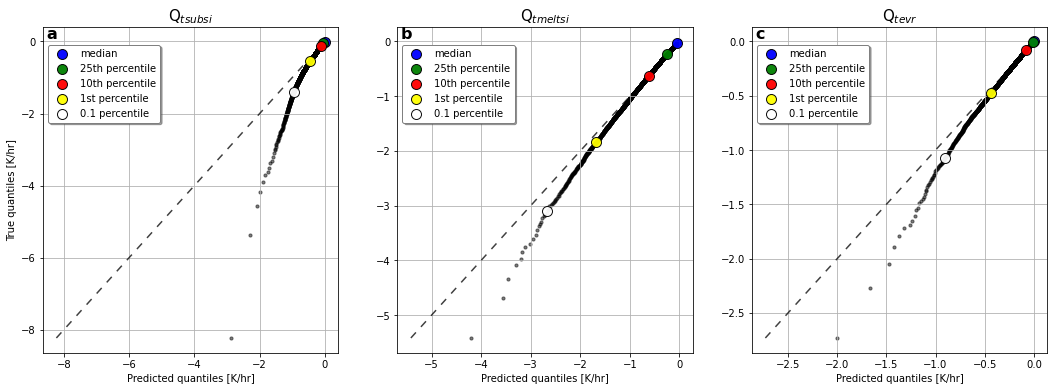

In [13]:
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(18,6))

nr_points = plot_helpers.plot_modified_qq_plot(ax=axes[0], y_pred=y_pred_tsubsi, y_true=y_val_tsubsi, subsample_factor=0.1)
axes[0].set_title(r'Q$_{tsubsi}$', fontsize=15)

nr_points = plot_helpers.plot_modified_qq_plot(ax=axes[1], y_pred=y_pred_tmeltsi, y_true=y_val_tmeltsi, subsample_factor=0.1, show_ylabel=False)
axes[1].set_title(r'Q$_{tmeltsi}$', fontsize=15)

nr_points = plot_helpers.plot_modified_qq_plot(ax=axes[2], y_pred=y_pred_tevr, y_true=y_val_tevr, subsample_factor=0.1, show_ylabel=False)
axes[2].set_title(r'Q$_{tevr}$', fontsize=15)

# Add labels to each subplot
labels = ['a', 'b', 'c']
for ax, label in zip(axes, labels):
    ax.text(0.01, 1, label, transform=ax.transAxes, fontsize=16, fontweight='bold', va='top')


plt.savefig(f'/home/freimax/msc_thesis/figures/thesis_msc/Chapter_RandomForest/QQplot.png',  bbox_inches='tight', dpi=200)
plt.show()

---
## Lagrangian view

In [14]:
df_big = pd.read_hdf('/net/helium/atmosdyn/freimax/data_msc/IFS-18/IFS-traj/trajectories/df_big_IFS18.h5', 'df')

In [15]:
df_big

,time,lon,lat,p,tmeltsi_pred,tsubsi_pred,tevr_pred,Atmeltsi_pred,Atsubsi_pred,Atevr_pred,...,OMEGA,T,SIWC,NOBCP_FLAG,date,id_CYC,month,Atsubsi_resid,Atmeltsi_resid,Atevr_resid
0,-48.0,-50.26,66.12,815.0,0.0,-0.043967,0.0,0.000000,-0.043967,0.000000,...,-0.306,-11.557,0.211,0.0,20171210_14,1.0,DEC17,0.008967,0.000000,0.000000
1,-47.0,-49.75,66.58,820.0,0.0,-0.189855,0.0,0.000000,-0.233822,0.000000,...,0.306,-10.790,0.050,0.0,20171210_14,1.0,DEC17,-0.054178,0.000000,0.000000
2,-46.0,-49.39,67.02,822.0,0.0,-0.146698,0.0,0.000000,-0.380520,0.000000,...,-0.096,-10.751,0.062,0.0,20171210_14,1.0,DEC17,-0.030480,0.000000,0.000000
3,-45.0,-49.11,67.46,813.0,0.0,-0.144842,0.0,0.000000,-0.525362,0.000000,...,-0.245,-11.502,0.092,0.0,20171210_14,1.0,DEC17,-0.003638,0.000000,0.000000
4,-44.0,-48.81,67.89,802.0,0.0,-0.093035,0.0,0.000000,-0.618397,0.000000,...,-0.352,-12.546,0.086,0.0,20171210_14,1.0,DEC17,0.000397,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164292,-4.0,-50.76,56.66,805.0,0.0,-0.024274,0.0,-0.283974,-1.047021,-4.018561,...,-0.815,-4.806,0.187,0.0,20181108_19,22.0,NOV18,0.326021,0.275974,-1.724439
164293,-3.0,-51.23,57.16,775.0,0.0,-0.019238,0.0,-0.283974,-1.066259,-4.018561,...,-0.840,-6.612,0.193,0.0,20181108_19,22.0,NOV18,0.341259,0.275974,-1.724439
164294,-2.0,-51.80,57.56,746.0,0.0,-0.030001,0.0,-0.283974,-1.096260,-4.018561,...,-0.708,-8.648,0.137,0.0,20181108_19,22.0,NOV18,0.371260,0.275974,-1.724439
164295,-1.0,-52.45,57.84,725.0,0.0,-0.018883,0.0,-0.283974,-1.115143,-4.018561,...,-0.429,-10.022,0.148,0.0,20181108_19,22.0,NOV18,0.390143,0.275974,-1.724439


In [16]:
df_big_t0 = df_big[df_big['time']==0]


In [17]:
fig_save_path='/home/freimax/msc_thesis/figures/thesis_msc/Chapter_RandomForest/lagr_perspective'

In [18]:
# Create a boolean mask where 'time' is 0
mask = (df_big['time'] == 0)

# Sum up the True values in the mask to get the count
count_time_zero = mask.sum()

print(f"The number of occurrences where time==0 is: {count_time_zero}")

The number of occurrences where time==0 is: 87853


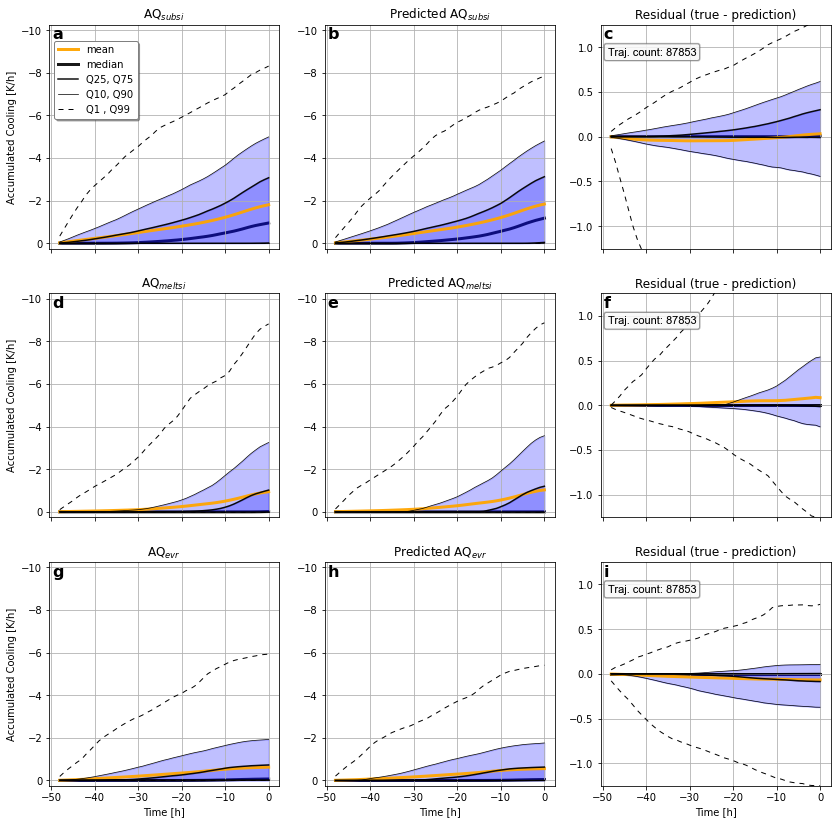

In [19]:
make_plots_traj.plot_accu_cooling_over_time(df_tr=df_big, 
                                            df_tr_rf=df_big, 
                                            truth_available=True, 
                                            text_box = 'traj_count',
                                            save_path=f'{fig_save_path}/timerseries_traj_cooling.png')

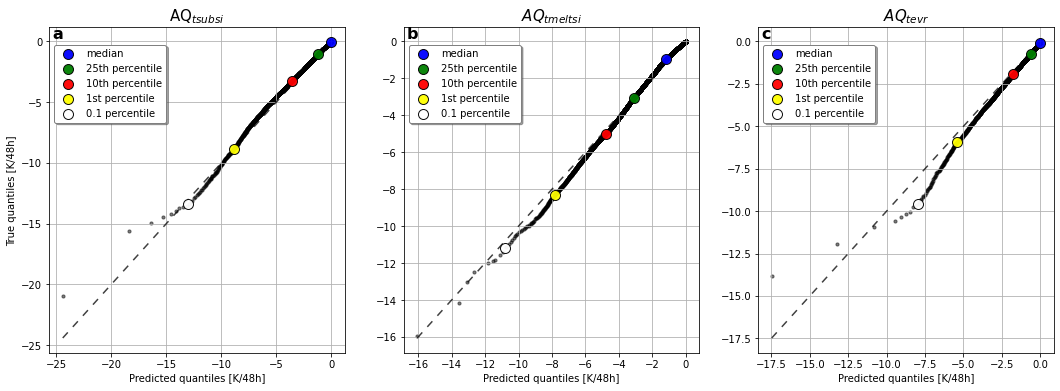

In [21]:
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(18,6))

nr_points = plot_helpers.plot_modified_qq_plot(ax=axes[0], y_true=df_big_t0['Atmeltsi'], y_pred=df_big_t0['Atmeltsi_pred'], subsample_factor=0.1, unit='[K/48h]')
axes[0].set_title(r'AQ$_{tsubsi}$', fontsize=15)

nr_points = plot_helpers.plot_modified_qq_plot(ax=axes[1], y_true=df_big_t0['Atsubsi'], y_pred=df_big_t0['Atsubsi_pred'], subsample_factor=0.1, show_ylabel=False, unit='[K/48h]')
axes[1].set_title(r'$AQ_{tmeltsi}$', fontsize=15)

nr_points = plot_helpers.plot_modified_qq_plot(ax=axes[2], y_true=df_big_t0['Atevr'], y_pred=df_big_t0['Atevr_pred'], subsample_factor=0.1, show_ylabel=False, unit='[K/48h]')
axes[2].set_title(r'$AQ_{tevr}$', fontsize=15)

# Add labels to each subplot
labels = ['a', 'b', 'c']
for ax, label in zip(axes, labels):
    ax.text(0.01, 1, label, transform=ax.transAxes, fontsize=16, fontweight='bold', va='top')

plt.savefig(f'/home/freimax/msc_thesis/figures/thesis_msc/Chapter_RandomForest/lagr_perspective/QQplot.png', bbox_inches='tight', dpi=200)
plt.show()

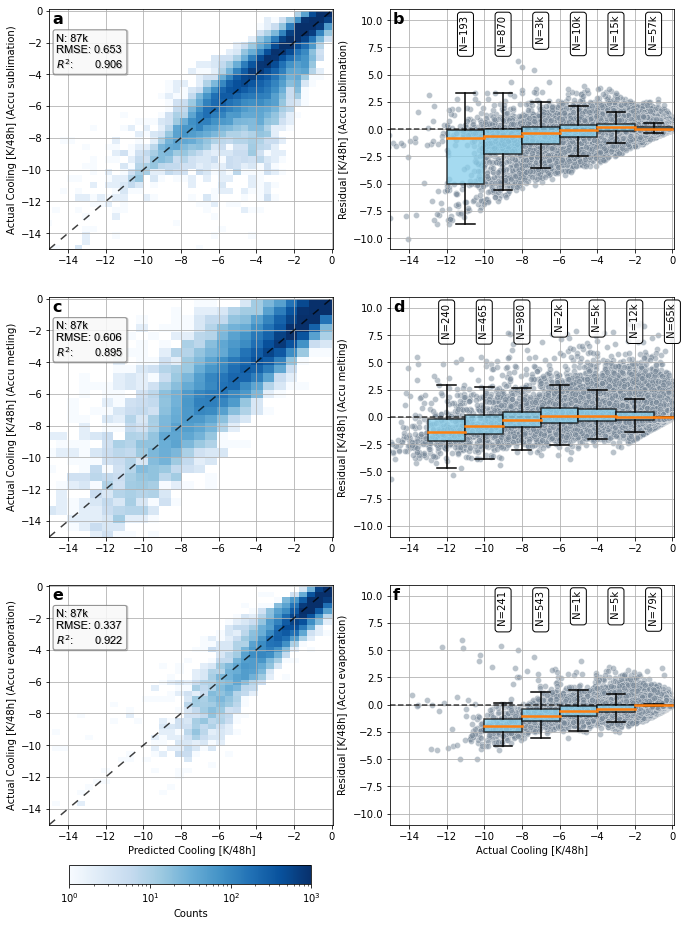

In [23]:


fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(11.2,15))
hist_2d=[]
## tsubsi
hist2d = make_plots_traj.plot_pred_vs_true(ax=ax[0,0], 
                           y_true=df_big_t0['Atsubsi'], 
                           y_pred=df_big_t0['Atsubsi_pred'], 
                           xaxis_label=False, xrange=-15, ylabel_bcp='Actual Cooling [K/48h] (Accu sublimation)')

make_plots_traj.plot_residuals(ax[0,1], 
               y_true=df_big_t0['Atsubsi'],
               y_pred=df_big_t0['Atsubsi_pred'],
               width_boxplot=2, 
               xaxis_label=False, xrange=-15, yrange=11, ylabel_bcp='Residual [K/48h] (Accu sublimation)')
hist_2d.append(hist2d)

## tmeltsi
hist2d = make_plots_traj.plot_pred_vs_true(ax=ax[1,0], 
                           y_true=df_big_t0['Atmeltsi'], 
                           y_pred=df_big_t0['Atmeltsi_pred'], 
                           xaxis_label=False, xrange=-15, ylabel_bcp='Actual Cooling [K/48h] (Accu metling)')

make_plots_traj.plot_residuals(ax[1,1], 
               y_true=df_big_t0['Atmeltsi'],
               y_pred=df_big_t0['Atmeltsi_pred'],
               width_boxplot=2, 
               xaxis_label=False, xrange=-15, yrange=11, ylabel_bcp='Residual [K/48h] (Accu melting)')
hist_2d.append(hist2d)


## tevr
hist2d = make_plots_traj.plot_pred_vs_true(ax=ax[2,0], 
                           y_true=df_big_t0['Atevr'], 
                           y_pred=df_big_t0['Atevr_pred'], 
                           xaxis_label=True, unit='[K/48h]', xrange=-15, ylabel_bcp='Actual Cooling [K/48h] (Accu evaporation)')

make_plots_traj.plot_residuals(ax[2,1], 
               y_true=df_big_t0['Atevr'],
               y_pred=df_big_t0['Atevr_pred'],
               width_boxplot=2, 
               xaxis_label=True, unit='[K/48h]', xrange=-15, yrange=11, ylabel_bcp='Residual [K/48h] (Accu evaporation)')
hist_2d.append(hist2d)


## Colorbar
cax = fig.add_axes([0.15, 0.07, 0.3, 0.0175]) # [left, bottom, width, height]
cbar_the = fig.colorbar(hist_2d[2][3], cax=cax, orientation='horizontal')#, pad=0.1, aspect=40)
cbar_the.set_label('Counts')


# Add labels to each subplot
labels = [['a', 'b'], ['c', 'd'], ['e', 'f']]
for row in range(3):
    for col in range(2):
        label= labels[row][col]
        ax[row,col].text(0.01, 0.99, label, transform=ax[row,col].transAxes, fontsize=16, fontweight='bold', va='top')

plt.savefig(f'/home/freimax/msc_thesis/figures/thesis_msc/Chapter_RandomForest/lagr_perspective/predVStrue_resid.png', bbox_inches='tight',dpi=250)